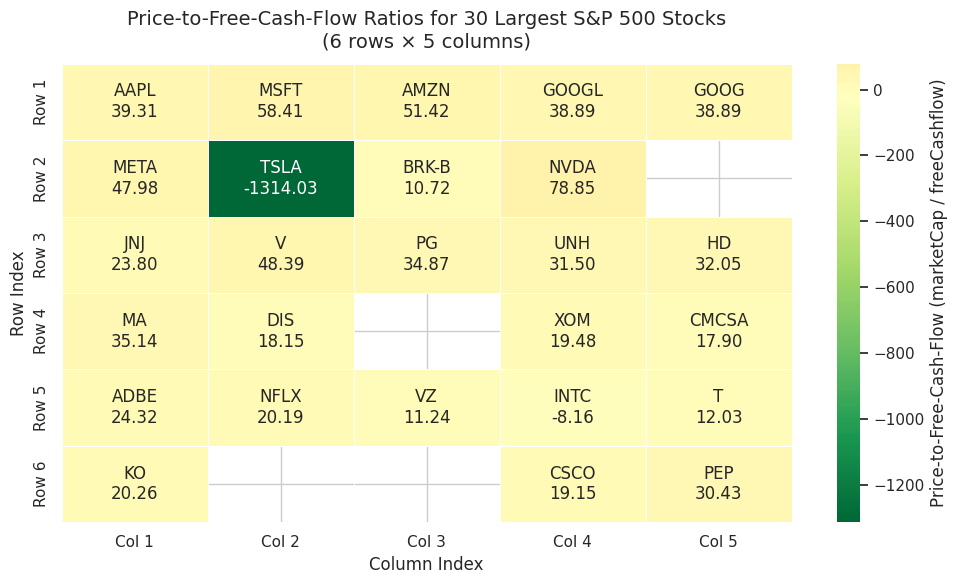

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# 1) Define the 30 largest S&P 500 stocks (example list; actual may vary).
largest_30 = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'BRK-B',
    'NVDA', 'JPM', 'JNJ', 'V', 'PG', 'UNH', 'HD', 'MA', 'DIS', 'BAC',
    'XOM', 'CMCSA', 'ADBE', 'NFLX', 'VZ', 'INTC', 'T', 'KO', 'PFE',
    'MRK', 'CSCO', 'PEP'
]

# 2) Manually compute Price-to-Free-Cash-Flow (P/FCF) using marketCap / freeCashflow
pfcf_ratios = {}
for ticker in largest_30:
    try:
        info = yf.Ticker(ticker).info

        market_cap = info.get('marketCap', None)
        free_cf   = info.get('freeCashflow', None)

        # Compute P/FCF if both marketCap and freeCashflow are present and freeCashflow != 0
        if market_cap is not None and free_cf is not None and free_cf != 0:
            pfcf_ratios[ticker] = market_cap / free_cf
        else:
            pfcf_ratios[ticker] = None
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        pfcf_ratios[ticker] = None

# 3) Prepare a 6 (rows) x 5 (columns) matrix for P/FCF values (5 values per row).
chunk_size = 5  # 5 values per row
n_rows = len(largest_30) // chunk_size  # = 6 rows

pfcf_matrix = np.full((n_rows, chunk_size), np.nan)
annot_matrix = np.empty((n_rows, chunk_size), dtype=object)

for i, ticker in enumerate(largest_30):
    row = i // chunk_size
    col = i % chunk_size
    pfcf_val = pfcf_ratios[ticker]

    # Fill the numeric matrix
    pfcf_matrix[row, col] = pfcf_val if pfcf_val is not None else np.nan

    # Fill the annotation matrix with the ticker and P/FCF ratio (or "N/A" if missing)
    if pfcf_val is not None:
        annot_matrix[row, col] = f"{ticker}\n{pfcf_val:.2f}"
    else:
        annot_matrix[row, col] = f"{ticker}\nN/A"

# Convert the numeric matrix to a DataFrame for plotting.
df_pfcf = pd.DataFrame(
    pfcf_matrix,
    index=[f"Row {r+1}" for r in range(n_rows)],
    columns=[f"Col {c+1}" for c in range(chunk_size)]
)

# 4) Handle the case where everything might still be NaN
valid_data = pfcf_matrix[~np.isnan(pfcf_matrix)]
if valid_data.size > 0:
    min_val = valid_data.min()
    max_val = valid_data.max()
    mean_val = valid_data.mean()
else:
    # If absolutely no valid data is found, set arbitrary scale to avoid errors
    min_val, max_val, mean_val = 0, 1, 0.5

# 5) Plot the heatmap.
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_pfcf,
    cmap='RdYlGn_r',  # Reversed palette: lower P/FCF in green, higher in red
    annot=annot_matrix,
    fmt='',
    linewidths=0.5,
    center=mean_val,
    vmin=min_val,
    vmax=max_val,
    cbar_kws={'label': 'Price-to-Free-Cash-Flow (marketCap / freeCashflow)'}
)

plt.title("Price-to-Free-Cash-Flow Ratios for 30 Largest S&P 500 Stocks\n(6 rows × 5 columns)",
          fontsize=14, pad=12)
plt.xlabel("Column Index", fontsize=12)
plt.ylabel("Row Index", fontsize=12)
plt.tight_layout()
plt.show()
